
# Trajectory Prediction (Conv1D, RNN, LSTM, BiLSTM, GRU, BiGRU) + Map Visualization

This notebook:
- Preprocesses the provided GPS trip dataset (`longitude`, `latitude`, `speed`, `bearing`, timestamps, `tripId`).
- Builds sliding window sequences (T=10 by default) and predicts the **next (longitude, latitude)**.
- Trains and compares: **RNN**, **LSTM**, **BiLSTM**, **GRU**, **BiGRU**, **Conv1D** (1D CNN).
- Selects the best model by **Haversine MAE** on a time-ordered validation/test split.
- Visualizes **Actual vs Predicted path** for each `tripId` using Matplotlib and Folium (interactive map).

> Works on Google Colab or local Jupyter. If running in Colab, upload your CSV when prompted.


In [1]:

# If running in Colab, uncomment the next cell to install deps (torch, folium)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install folium scikit-learn pandas matplotlib

import os, sys, math, json, random, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader, TensorDataset, Dataset
except Exception as e:
    print("If you're on Colab, run the pip install cell above. Error:", e)
    raise

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from datetime import datetime
from collections import defaultdict

# Optional: interactive maps
try:
    import folium
    HAS_FOLIUM = True
except Exception:
    HAS_FOLIUM = False

# Reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [2]:

# === Load your CSV ===
# Option A: If running locally, set the path below:
CSV_PATH = 'Sample Trip Data - new.csv'

# Option B (Colab): upload file interactively
if not os.path.exists(CSV_PATH):
    try:
        from google.colab import files
        uploaded = files.upload()
        CSV_PATH = list(uploaded.keys())[0]
        print("Uploaded:", CSV_PATH)
    except Exception as e:
        print("Could not auto-upload. Please set CSV_PATH to your file path. Error:", e)

df_raw = pd.read_csv(CSV_PATH)
print("Rows:", len(df_raw), "Columns:", list(df_raw.columns))
df_raw.head()


Rows: 9238 Columns: ['Unnamed: 0', 'tripId', 'longitude', 'latitude', 'speed', 'bearing', 'trackingDate', 'createdDate', 'boatId', 'distance', 'UnixTime Stamp']


,Unnamed: 0,tripId,longitude,latitude,speed,bearing,trackingDate,createdDate,boatId,distance,UnixTime Stamp
0,0,395,76.461801,9.136093,1.445881,290,12/19/2017 23:23:00,01/04/2018 14:33:00,\N,1050,NaN
1,1,395,76.461736,9.136102,1.381843,272,12/19/2017 23:23:00,01/04/2018 14:33:00,\N,1050,NaN
2,2,395,76.461673,9.136099,1.507152,269,12/19/2017 23:23:00,01/04/2018 14:33:00,\N,1050,NaN
3,3,395,76.461592,9.136115,1.602837,269,12/19/2017 23:23:00,01/04/2018 14:33:00,\N,1050,NaN
4,4,395,76.461524,9.136089,1.653675,259,12/19/2017 23:24:00,01/04/2018 14:33:00,\N,1050,NaN


In [3]:

def preprocess_build_sequences(df: pd.DataFrame, seq_len=10):
    """
    - Clean numeric fields: longitude, latitude, speed, bearing
    - Parse timestamps (trackingDate or createdDate)
    - Use tripId as sequence grouping id
    - Standardize features [lon, lat, speed, bearing], build sliding windows of length seq_len
      predicting next (lon, lat).
    - Time-ordered split per trip into train/val/test (70/15/15)
    Returns: dict with arrays and scalers/metadata
    """
    d = df.copy()
    d.columns = [c.strip().replace(' ', '_') for c in d.columns]
    # Coerce numerics
    for c in ['longitude','latitude','speed','bearing','distance']:
        if c in d.columns:
            d[c] = pd.to_numeric(d[c], errors='coerce')
    # Parse datetimes
    for c in ['trackingDate','createdDate']:
        if c in d.columns:
            d[c] = pd.to_datetime(d[c], errors='coerce', infer_datetime_format=True)
    # pick time
    if 'trackingDate' in d.columns and d['trackingDate'].notna().any():
        d['time'] = d['trackingDate']
    elif 'createdDate' in d.columns and d['createdDate'].notna().any():
        d['time'] = d['createdDate']
    else:
        # fallback: sequential time
        d['time'] = pd.Timestamp('2017-01-01') + pd.to_timedelta(np.arange(len(d)), unit='s')

    # group id: tripId (boatId often '\\N' in provided data)
    id_col = 'tripId' if 'tripId' in d.columns else None
    if id_col is None:
        raise ValueError("tripId column is required in this notebook.")

    # drop missing essentials
    d = d.dropna(subset=['longitude','latitude','speed','bearing','time', id_col]).copy()
    d = d.sort_values([id_col,'time']).reset_index(drop=True)

    feature_cols = ['longitude','latitude','speed','bearing']
    target_cols = ['longitude','latitude']

    scaler = StandardScaler()
    d[[f'f_{c}' for c in feature_cols]] = scaler.fit_transform(d[feature_cols].values.astype(np.float32))

    # Build sequences per trip
    X_list, y_list, id_list, t_list = [], [], [], []
    for gid, g in d.groupby(id_col):
        g = g.reset_index(drop=True)
        if len(g) <= seq_len:
            continue
        feats = g[[f'f_{c}' for c in feature_cols]].values.astype(np.float32)
        targs = g[target_cols].values.astype(np.float32)
        times = g['time'].values
        for i in range(len(g) - seq_len):
            X_list.append(feats[i:i+seq_len])
            y_list.append(targs[i+seq_len])
            id_list.append(gid)
            t_list.append(times[i+seq_len])

    X = np.array(X_list, dtype=np.float32)      # (N, T, F=4)
    y = np.array(y_list, dtype=np.float32)      # (N, 2) -> [lon, lat]
    ids = np.array(id_list)
    times = np.array(t_list)

    # Time-ordered split per trip: 70/15/15
    idx_train, idx_val, idx_test = [], [], []
    from math import ceil
    group_map = defaultdict(list)
    for i, gid in enumerate(ids):
        group_map[gid].append(i)

    for gid, idxs in group_map.items():
        idxs_sorted = sorted(idxs, key=lambda j: times[j])
        n = len(idxs_sorted)
        n_train = int(0.7*n)
        n_val = int(0.15*n)
        train = idxs_sorted[:n_train]
        val = idxs_sorted[n_train:n_train+n_val]
        test = idxs_sorted[n_train+n_val:]
        idx_train += train
        idx_val += val
        idx_test += test

    idx_train = np.array(idx_train)
    idx_val = np.array(idx_val)
    idx_test = np.array(idx_test)

    out = {
        'X': X, 'y': y, 'ids': ids, 'times': times, 'id_col': id_col,
        'idx_train': idx_train, 'idx_val': idx_val, 'idx_test': idx_test,
        'scaler': scaler, 'feature_cols': feature_cols, 'target_cols': target_cols, 'seq_len': seq_len
    }
    return out

data = preprocess_build_sequences(df_raw, seq_len=10)
for k in ['X','y','ids','idx_train','idx_val','idx_test']:
    if isinstance(data[k], np.ndarray):
        print(k, data[k].shape)
    else:
        print(k, type(data[k]))


X (3696, 10, 4)
y (3696, 2)
ids (3696,)
idx_train (2587,)
idx_val (553,)
idx_test (556,)


/tmp/ipython-input-2391716235.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d[c] = pd.to_datetime(d[c], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-2391716235.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  d[c] = pd.to_datetime(d[c], errors='coerce', infer_datetime_format=True)


In [4]:

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

X, y = data['X'], data['y']
idx_train, idx_val, idx_test = data['idx_train'], data['idx_val'], data['idx_test']

train_ds = SeqDataset(X[idx_train], y[idx_train])
val_ds   = SeqDataset(X[idx_val], y[idx_val])
test_ds  = SeqDataset(X[idx_test], y[idx_test])

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, drop_last=False)
val_loader   = DataLoader(val_ds, batch_size=256, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

input_size = X.shape[2]  # 4 features
seq_len = X.shape[1]
input_size, seq_len, len(train_ds), len(val_ds), len(test_ds)


(4, 10, 2587, 553, 556)

In [5]:

class RNNBase(nn.Module):
    def __init__(self, input_size, hidden=96, layers=1, bidirectional=False, cell='rnn', dropout=0.1):
        super().__init__()
        if cell == 'rnn':
            self.rnn = nn.RNN(input_size, hidden, num_layers=layers, batch_first=True, bidirectional=bidirectional, dropout=0 if layers==1 else dropout)
        elif cell == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden, num_layers=layers, batch_first=True, bidirectional=bidirectional, dropout=0 if layers==1 else dropout)
        elif cell == 'gru':
            self.rnn = nn.GRU(input_size, hidden, num_layers=layers, batch_first=True, bidirectional=bidirectional, dropout=0 if layers==1 else dropout)
        else:
            raise ValueError("cell must be one of {'rnn','lstm','gru'}")
        out_dim = hidden * (2 if bidirectional else 1)
        self.head = nn.Sequential(
            nn.LayerNorm(out_dim),
            nn.Linear(out_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)  # predict [lon, lat]
        )
    def forward(self, x):
        o, _ = self.rnn(x)     # (B, T, H*(2?))
        last = o[:, -1, :]     # last timestep
        return self.head(last)

class CNN1D(nn.Module):
    def __init__(self, input_size, hidden=96):
        super().__init__()
        self.fe = nn.Sequential(
            nn.Conv1d(input_size, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(hidden, hidden, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.LayerNorm(hidden),
            nn.Linear(hidden, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        x = x.transpose(1, 2)  # (B, F, T)
        z = self.fe(x)         # (B, H, 1)
        return self.head(z)    # (B, 2)


In [6]:

def haversine_m(pred, truth):
    # pred/truth: (N,2) [lon,lat] in degrees
    R = 6371000.0
    lon1 = np.deg2rad(pred[:,0]); lat1 = np.deg2rad(pred[:,1])
    lon2 = np.deg2rad(truth[:,0]); lat2 = np.deg2rad(truth[:,1])
    dlon = lon2 - lon1; dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2.0)**2
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return R * c

def run_train(model, train_loader, val_loader, epochs=40, lr=1e-3, patience=6):
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.SmoothL1Loss()
    best_val = float('inf'); best_state = None; wait = 0

    for ep in range(1, epochs+1):
        model.train()
        total = 0.0
        n = 0
        for xb, yb in train_loader:
            xb = xb.to(device); yb = yb.to(device)
            opt.zero_grad()
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
            n += xb.size(0)
        train_loss = total / max(1,n)

        # val
        model.eval()
        with torch.no_grad():
            vtotal = 0.0; vn = 0
            v_preds = []; v_truth = []
            for xb, yb in val_loader:
                xb = xb.to(device); yb = yb.to(device)
                p = model(xb)
                loss = loss_fn(p, yb)
                vtotal += loss.item() * xb.size(0); vn += xb.size(0)
                v_preds.append(p.detach().cpu().numpy())
                v_truth.append(yb.detach().cpu().numpy())
            val_loss = vtotal / max(1,vn)
            v_preds = np.vstack(v_preds); v_truth = np.vstack(v_truth)
            val_mae_m = float(haversine_m(v_preds, v_truth).mean()) if len(v_preds)>0 else np.nan

        print(f"Epoch {ep:03d}/{epochs} | train_loss={train_loss:.5f} | val_loss={val_loss:.5f} | val_Haversine_MAE={val_mae_m:.2f} m")

        # early stopping on val_loss
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = {k: v.cpu().clone() for k,v in model.state_dict().items()}
            wait = 0
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def evaluate(model, loader):
    model.eval()
    preds = []; truth = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            p = model(xb).cpu().numpy()
            preds.append(p); truth.append(yb.numpy())
    preds = np.vstack(preds); truth = np.vstack(truth)
    mae = float(haversine_m(preds, truth).mean()) if len(preds)>0 else float('nan')
    rmse = float(np.sqrt(((haversine_m(preds, truth))**2).mean())) if len(preds)>0 else float('nan')
    return preds, truth, mae, rmse


In [7]:

candidates = [
    ("RNN",     lambda: RNNBase(input_size, hidden=96, layers=1, bidirectional=False, cell='rnn')),
    ("LSTM",    lambda: RNNBase(input_size, hidden=96, layers=1, bidirectional=False, cell='lstm')),
    ("BiLSTM",  lambda: RNNBase(input_size, hidden=96, layers=1, bidirectional=True,  cell='lstm')),
    ("GRU",     lambda: RNNBase(input_size, hidden=96, layers=1, bidirectional=False, cell='gru')),
    ("BiGRU",   lambda: RNNBase(input_size, hidden=96, layers=1, bidirectional=True,  cell='gru')),
    ("Conv1D",  lambda: CNN1D(input_size, hidden=96)),
]

results = []
for name, ctor in candidates:
    print("\n==== Training:", name, "====")
    model = ctor()
    model = run_train(model, train_loader, val_loader, epochs=40, lr=1e-3, patience=6)
    pred_val, truth_val, mae_val, rmse_val = evaluate(model, val_loader)
    pred_test, truth_test, mae_test, rmse_test = evaluate(model, test_loader)
    results.append({
        'name': name,
        'val_mae_m': mae_val,
        'val_rmse_m': rmse_val,
        'test_mae_m': mae_test,
        'test_rmse_m': rmse_test,
        'model': model,
        'pred_test': pred_test,
        'truth_test': truth_test
    })

# Show comparison
pd.DataFrame([{k:v for k,v in r.items() if k!='model' and not isinstance(v, np.ndarray)} for r in results]).sort_values('val_mae_m')



==== Training: RNN ====
Epoch 001/40 | train_loss=40.86001 | val_loss=39.17057 | val_Haversine_MAE=8105284.00 m
Epoch 002/40 | train_loss=37.12898 | val_loss=33.86315 | val_Haversine_MAE=7430959.00 m
Epoch 003/40 | train_loss=32.42721 | val_loss=30.23014 | val_Haversine_MAE=6622429.50 m
Epoch 004/40 | train_loss=28.40574 | val_loss=25.34662 | val_Haversine_MAE=5609823.00 m
Epoch 005/40 | train_loss=22.89225 | val_loss=18.72706 | val_Haversine_MAE=4162967.50 m
Epoch 006/40 | train_loss=15.28811 | val_loss=9.44167 | val_Haversine_MAE=2127183.25 m
Epoch 007/40 | train_loss=4.99554 | val_loss=1.81325 | val_Haversine_MAE=452974.06 m
Epoch 008/40 | train_loss=2.86645 | val_loss=0.52463 | val_Haversine_MAE=168738.47 m
Epoch 009/40 | train_loss=1.65653 | val_loss=0.07805 | val_Haversine_MAE=61083.88 m
Epoch 010/40 | train_loss=1.33986 | val_loss=0.32350 | val_Haversine_MAE=125882.05 m
Epoch 011/40 | train_loss=1.34549 | val_loss=0.00743 | val_Haversine_MAE=14883.27 m
Epoch 012/40 | train_loss

,name,val_mae_m,val_rmse_m,test_mae_m,test_rmse_m
0,RNN,8184.264160,8545.541016,13837.053711,135281.296875
3,GRU,8924.942383,10789.131836,22131.859375,90362.726562
1,LSTM,14880.241211,15686.377930,20645.171875,105889.070312
5,Conv1D,15817.341797,17031.574219,14050.117188,17287.818359
4,BiGRU,76991.523438,218881.859375,266750.718750,551888.250000
2,BiLSTM,90952.031250,363352.968750,446258.593750,983567.937500


In [8]:

# Pick best by validation MAE
best = sorted(results, key=lambda r: r['val_mae_m'])[0]
best_name = best['name']
best_model = best['model']
print("Best model:", best_name, "| Val MAE (m):", best['val_mae_m'], "| Test MAE (m):", best['test_mae_m'])

# Save predictions csv for test set
ids = data['ids']; idx_test = data['idx_test']
pred_test = best['pred_test']; truth_test = best['truth_test']
test_ids = ids[idx_test]

pred_df = pd.DataFrame({
    'tripId': test_ids,
    'true_lon': truth_test[:,0],
    'true_lat': truth_test[:,1],
    'pred_lon': pred_test[:,0],
    'pred_lat': pred_test[:,1],
})
pred_csv = f"predictions_{best_name.lower()}_test.csv"
pred_df.to_csv(pred_csv, index=False)
print("Saved:", pred_csv)
pred_df.head()


Best model: RNN | Val MAE (m): 8184.26416015625 | Test MAE (m): 13837.0537109375
Saved: predictions_rnn_test.csv


,tripId,true_lon,true_lat,pred_lon,pred_lat
0,395,76.470329,9.130499,76.481857,9.189124
1,395,76.470322,9.130489,76.482819,9.189265
2,395,76.470337,9.130498,76.485123,9.189759
3,395,76.470337,9.130502,76.485176,9.189673
4,395,76.470345,9.130506,76.481705,9.188958


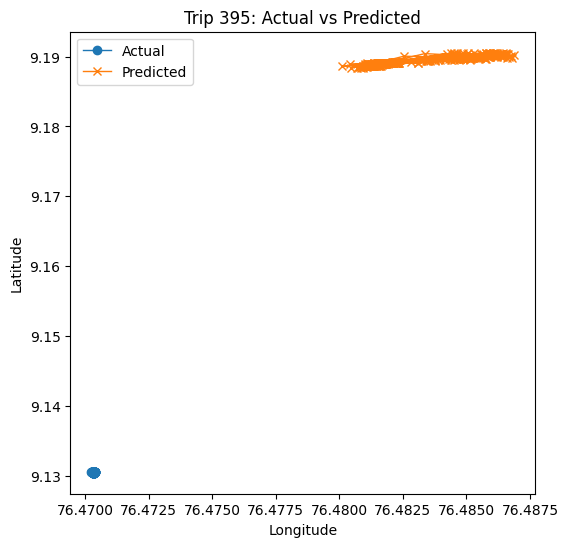

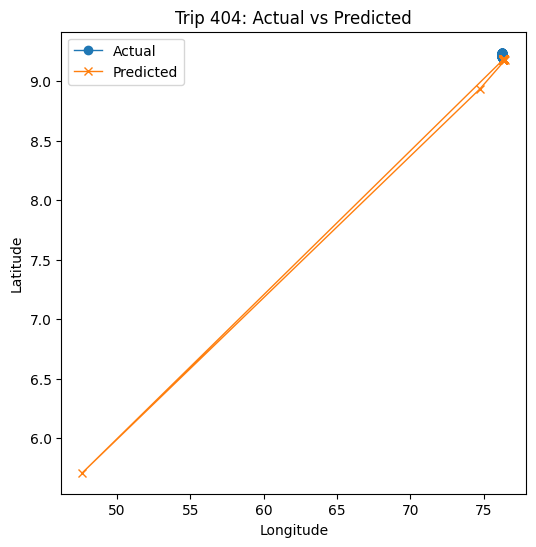

In [9]:

# Matplotlib: Actual vs Predicted per trip on lon/lat plane
import os
plot_dir = 'plots_matplotlib'; os.makedirs(plot_dir, exist_ok=True)
for trip in pd.Series(pred_df['tripId']).unique():
    m = pred_df['tripId'] == trip
    if m.sum() < 2:
        continue
    tp = pred_df.loc[m, ['true_lon','true_lat']].values
    pp = pred_df.loc[m, ['pred_lon','pred_lat']].values

    plt.figure(figsize=(6,6))
    plt.plot(tp[:,0], tp[:,1], marker='o', linewidth=1, label='Actual')
    plt.plot(pp[:,0], pp[:,1], marker='x', linewidth=1, label='Predicted')
    plt.xlabel('Longitude'); plt.ylabel('Latitude')
    plt.title(f'Trip {trip}: Actual vs Predicted')
    plt.legend()
    out = os.path.join(plot_dir, f'trip_{trip}_matplot.png')
    plt.savefig(out, dpi=150, bbox_inches='tight')
    plt.show()


In [10]:

# Folium: interactive maps (polylines). Saves one HTML per trip.
if HAS_FOLIUM:
    map_dir = 'maps_folium'; os.makedirs(map_dir, exist_ok=True)
    for trip in pd.Series(pred_df['tripId']).unique():
        msk = pred_df['tripId'] == trip
        if msk.sum() < 2:
            continue
        # Extract lat/lon for folium (lat, lon order)
        true_coords = pred_df.loc[msk, ['true_lat','true_lon']].values.tolist()
        pred_coords = pred_df.loc[msk, ['pred_lat','pred_lon']].values.tolist()

        # Center map around first true point
        center = true_coords[0]
        fmap = folium.Map(location=center, zoom_start=14, tiles='OpenStreetMap')

        folium.PolyLine(true_coords, weight=4, opacity=0.8, tooltip=f'Trip {trip} Actual').add_to(fmap)
        folium.PolyLine(pred_coords, weight=4, opacity=0.8, tooltip=f'Trip {trip} Predicted', color='red').add_to(fmap)

        folium.Marker(true_coords[0], popup='Start Actual').add_to(fmap)
        folium.Marker(true_coords[-1], popup='End Actual').add_to(fmap)
        folium.Marker(pred_coords[0], popup='Start Predicted', icon=folium.Icon(color='red')).add_to(fmap)
        folium.Marker(pred_coords[-1], popup='End Predicted', icon=folium.Icon(color='red')).add_to(fmap)

        out_html = os.path.join(map_dir, f'trip_{trip}_map.html')
        fmap.save(out_html)
        display(f"Saved map: {out_html}")
else:
    print("Folium not installed. Skip interactive maps. You can install it and re-run this cell.")


'Saved map: maps_folium/trip_395_map.html'

'Saved map: maps_folium/trip_404_map.html'

In [11]:

# OPTIONAL: function to predict next step for a given last sequence window (T x F)
def predict_next(best_model, last_window_features):
    best_model.eval()
    x = torch.tensor(last_window_features, dtype=torch.float32).unsqueeze(0).to(device)  # (1, T, F)
    with torch.no_grad():
        p = best_model(x).cpu().numpy()[0]
    return float(p[0]), float(p[1])  # lon, lat
